In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Load the data
df = pd.read_csv('./processedData.csv')

# Parse the 'Full date' column and set it as index
df['Full date'] = pd.to_datetime(df['Full date'])
df.set_index('Full date', inplace=True)

# Feature Engineering: Extract features from the date
df['DayOfYear'] = df.index.dayofyear
df['Month'] = df.index.month
df['Day'] = df.index.day
df['Year'] = df.index.year

# Normalize the target variable (Temp Max)
scaler = MinMaxScaler(feature_range=(0, 1))
df['Temp Max'] = scaler.fit_transform(df['Temp Max'].values.reshape(-1, 1))

# Prepare the data for LSTM
data = df[['Temp Max']].values
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# Function to create a dataset suitable for LSTM
def create_dataset(dataset, time_step=1):
    X, y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), 0])
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

# Create dataset with a reasonable time_step
time_step = 30  # Adjust as needed
X_train, y_train = create_dataset(train, time_step)
X_test, y_test = create_dataset(test, time_step)

# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Create DataLoader
batch_size = 64  # Adjust based on your memory capacity
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# Define LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Get the last time step output
        return out

# Initialize model, loss function and optimizer
model = LSTM().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 10  # Adjust based on your requirements
for epoch in range(num_epochs):
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs.squeeze(), batch_y)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')



Using device: cuda
Epoch [1/10], Loss: 0.0053
Epoch [2/10], Loss: 0.0033
Epoch [3/10], Loss: 0.0039
Epoch [4/10], Loss: 0.0034
Epoch [5/10], Loss: 0.0025
Epoch [6/10], Loss: 0.0034
Epoch [7/10], Loss: 0.0026
Epoch [8/10], Loss: 0.0019
Epoch [9/10], Loss: 0.0019
Epoch [10/10], Loss: 0.0029


Manual R² Score: 0.9221545464406921


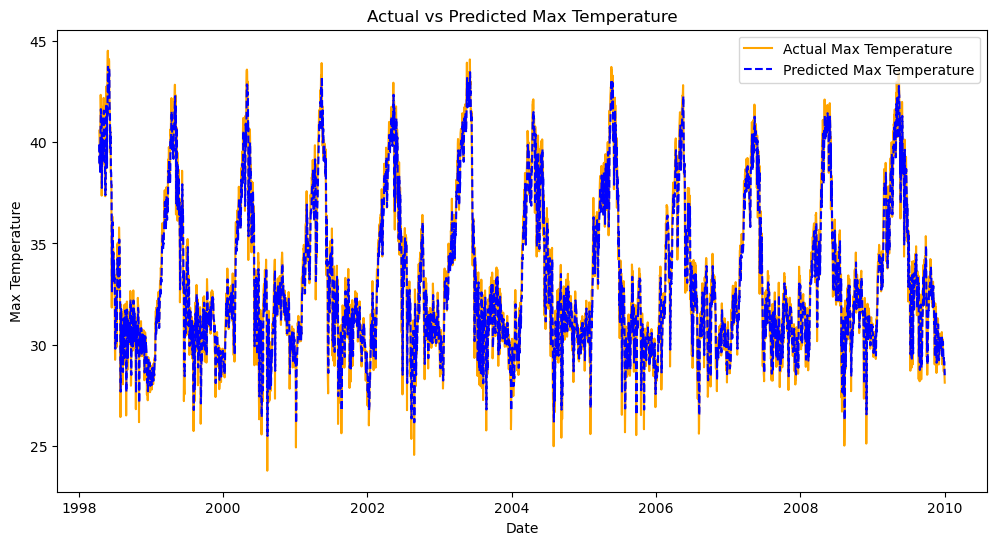

In [6]:
def calculate_r2(y_true, y_pred):
    ss_total = ((y_true - np.mean(y_true)) ** 2).sum()
    ss_residual = ((y_true - y_pred) ** 2).sum()
    r2_score = 1 - (ss_residual / ss_total)
    return r2_score
# Evaluate the model
model.eval()
with torch.no_grad():
    test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    predictions = model(test_tensor).cpu().numpy()

# Inverse transform predictions to original scale
predictions = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()

# Inverse transform y_test to original scale
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Calculate R² Score using the original scale
r2 = calculate_r2(y_test_original, predictions)
print(f'Manual R² Score: {r2}')

# Visualize actual vs predicted temperatures
plt.figure(figsize=(12, 6))
plt.plot(df.index[train_size + time_step + 1:], y_test_original, label='Actual Max Temperature', color='orange')
plt.plot(df.index[train_size + time_step + 1:], predictions, label='Predicted Max Temperature', color='blue', linestyle='--')
plt.title('Actual vs Predicted Max Temperature')
plt.xlabel('Date')
plt.ylabel('Max Temperature')
plt.legend()
plt.show()
